Create a simple Grover Search to locate a valid Othello move in a 3 x 3 representation of a section of the board.

This model will then be extended to 4 x 4 model.

The search can identify cells above/below/left or right. diagonal.



In [1]:
import numpy as np
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, ClassicalRegister, QuantumRegister, execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *


# import basic plot tools
from qiskit.tools.visualization import plot_histogram

# Loading your IBM Q account(s)
provider = IBMQ.load_account()

Set up an example 3x3 board to use in the search.  1 represents a tile in place. 0 represents no tile.
At this point we are not distinguishing between tile colours.  

In [45]:
# Board A.  Only valid move is first Tile
# 011
# 111
# 111
boardA = [ 0, 1, 1, 1, 1, 1, 1, 1, 1]

# Board B.  Has Seven Valid moves
#000
#010
#010 
boardB = [ 0, 0, 0, 0, 1, 0, 0, 1, 0]

# Board C.  Has 5 Valid moves
# 000
# 000
# 010
boardC = [ 0, 0, 0, 0, 0, 0, 0, 1, 0]

# Board D.  Has 2 Valid moves
# 001
# 111
# 111
boardD = [ 0, 0, 1, 1, 1, 1, 1, 1, 1]

Define a phase oracle for use in the Grover's search. This oracle will identify states that are valid moves.
We will also need a diffusion circuit for the amplification.

Test this ciruit for only one answer. 

Then change the board so that there are more valid answers.  The diffusion circuit will need to change.  

Finally examine what the maximum number of valid answers on a 3x3 board are, as this will impact on how the Grover circuit is constructed.  Too many answers will impact on how easy it is to detect them.


In [46]:
# Params : circuit, BoardState, Auxillary Qubits, oracle
def othello_3x3_oracle(qc, boardQ, auxillary, oracle):
    
    #Compute the search for the valid moves 
    # Start with contrived solution, Use a board with only 1 free space. The only valid answer is of the form 100 000 000
    #qc.cx(auxillary[0],boardQ[0])
    qc.cx(auxillary,boardQ)
    
    qc.mct(boardQ, oracle)  ### If the board is solved flip the output bit. 
    #Phase kickback because output_qubit is in superposition
    
    #Uncompute the search for the valid moves
    #qc.cx(auxillary[0],boardQ[0])
    qc.cx(auxillary,boardQ)
    
    return



Generic Diffuser Circuit for Grover Search

In [47]:
def diffuser(nqubits):
    qcDiff = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qcDiff.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qcDiff.x(qubit)
    # Do multi-controlled-Z gate
    qcDiff.h(nqubits-1)
    qcDiff.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qcDiff.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qcDiff.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qcDiff.h(qubit)
    # We will return the diffuser as a gate
    U_s = qcDiff.to_gate()
    U_s.name = "$U_s$"
    return U_s

Define a circuit to bring it all together.

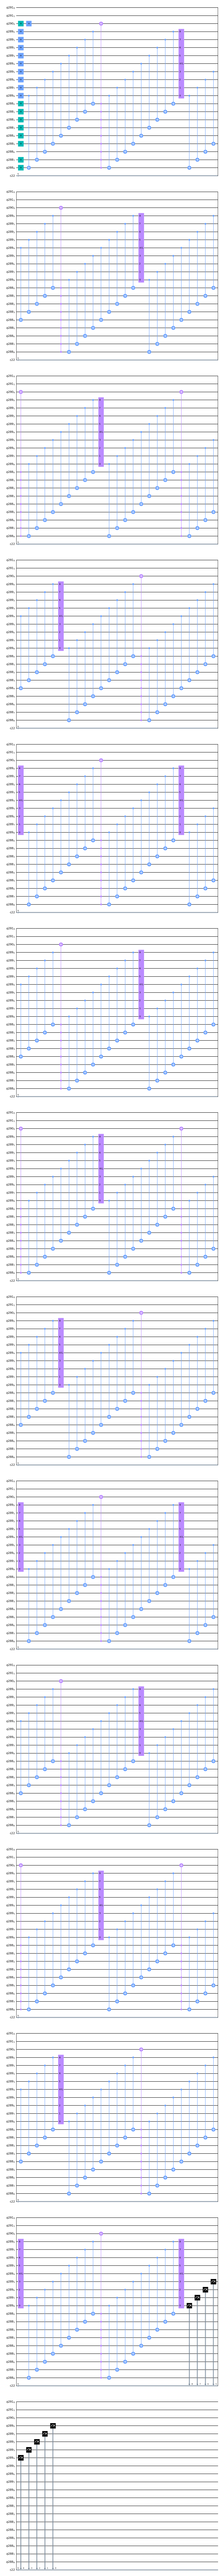

In [65]:
            
def othelloMoveSearch ( boardRepresentation ):
    # Create a 9 Qubit Register for the Quantum represntation of the board.    
    boardQ = QuantumRegister(9)
    # Create a 9 Qubit Register for Auxillary Qubits for Grover Search
    auxillary = QuantumRegister(9)
    # Create a single Qubit Register for the Grover Search Oracle
    oracle = QuantumRegister(1)
    # Create a 2 Qubit Quantum Register [Not used yet]
    qr = QuantumRegister(2)
    # Create a 9 Bit Classical Register for the output
    cr = ClassicalRegister(9)
    
    # Create a quantum circuit containing the registers above
    qc = QuantumCircuit(boardQ, auxillary, oracle, qr, cr)
    
    # Put the Auxillary Qubits into SuperPosition of the Results.
    qc.h(auxillary[:])
    
    # Prepare the Oracle Qubit
    qc.x(oracle[0])
    qc.h(oracle[0])
    
    # Set up the Quantum Representation of the board to match the current state of the board
    for x in range(len( boardRepresentation )): 
        if boardRepresentation[x] > 0 :
            qc.x(boardQ[x])
    
    # Call the Grover Algorithm and Diffuser 16 times [Number of iterations varies according to search]
    for i in range (16) :
        othello_3x3_oracle(qc, boardQ, auxillary, oracle)
        qc.append(diffuser(9), [9,10,11,12,13,14,15,16,17])
    
    # Measure the status of the Quantum Board to verify the setup has worked. 
    qc.measure(auxillary,cr)
        
    # Change the endian 
    qc = qc.reverse_bits() 
    #print ("Diagnostic Log 001")
    return qc

# Create the circuit and print it on screen
qc1 = othelloMoveSearch( boardA )
qc1.draw(output="mpl")


Execute the circuit and see the results.

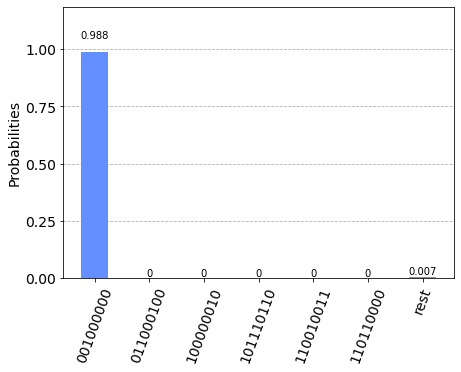

In [66]:
#backend = BasicAer.get_backend('qasm_simulator')
backend = Aer.get_backend('qasm_simulator')
shots = 1024
results = execute(qc1, backend=backend, shots=shots).result()
answer = results.get_counts()
plot_histogram(answer, number_to_keep=6)


